## Importing necessary libraries

In [71]:
# to load data from json file
import json

# to store & manipulate data
import numpy as np 
import pandas as pd

# to plot data
import matplotlib.pyplot as plt 

# different classification models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# to plot the decision tree
from sklearn import tree

## Loading Data into a Pandas Dataframe

In [2]:
# load data from json file to data1 of type dictionary
data1 = json.load(open('data.json'))

# function to join data from different locations of same type
def join_dicts(ds): 
 new_d = dict()
 for d in ds:
     for key in d.keys(): new_d[key] = d[key]
 return new_d

# data from each location type is joined together. For e.g., 'rewe' and 'aldi' belong in 'super_market'
data2 = {
 'public_transport': join_dicts([data1['bus']]), 
 'outdoors': join_dicts([data1['busstop'], data1['outdoors']]), 
 'indoors': join_dicts([data1['ashokroom'], data1['harsharoom'], data1['himaniroom'], data1['darpanroom'], data1['adarshroom'], data1['kotaroom']]),
 'super_market': join_dicts([data1['rewe'], data1['aldi']])
}

locations = list(data2.keys())
print('data collected in location types:\n',locations)

data collected in location types:
 ['public_transport', 'outdoors', 'indoors', 'super_market']


## Convert raw data into Features

In [3]:
# function to convert data from string to a list of attribute values
def parse(x): 
 start = x.find('device=')+7; end = start+x[start:].find(",")
 device = x[start:end]; x=x[end:]
 start = x.find('mAdvertiseFlags=')+16; end = start+x[start:].find(",")
 mAdvertiseFlags = int(x[start:end]); x=x[end:]
 start = x.find('mTxPowerLevel=')+14; end = start+x[start:].find(",")
 mTxPowerLevel = int(x[start:end]); x=x[end:]
 start = x.find('rssi=')+5; end = start+x[start:].find(",")
 rssi = int(x[start:end]); x=x[end:]
 start = x.find('timestampNanos=')+15; end = start+x[start:].find(",")
 timestampNanos = int(x[start:end]);x=x[end:]
 start = x.find('eventType=')+10; end = start+x[start:].find(",")
 eventType = int(x[start:end]); x=x[end:]
 start = x.find('primaryPhy=')+11; end = start+x[start:].find(",")
 primaryPhy = int(x[start:end]); x=x[end:]
 start = x.find('secondaryPhy=')+13; end = start+x[start:].find(",")
 secondaryPhy = int(x[start:end]); x=x[end:]
 start = x.find('advertisingSid=')+15; end = start+x[start:].find(",")
 advertisingSid = int(x[start:end]); x=x[end:]
 start = x.find('txPower=')+8; end = start+x[start:].find(",")
 txPower = int(x[start:end]); x=x[end:]
 start = x.find('periodicAdvertisingInterval=')+28; end = start+x[start:].find("}")
 periodicAdvertisingInterval = x[start:end]; x=x[end:]
 if mTxPowerLevel<-999: mTxPowerLevel = 0
 return [ timestampNanos, device, mAdvertiseFlags, mTxPowerLevel, rssi, eventType, primaryPhy, secondaryPhy, advertisingSid, txPower, periodicAdvertisingInterval ]

# these are the attributes collected from the ble beacons
columns1 = ["timestamp", "device_id", "advertise_flag", "transmission_power", "rssi", "event_type", "primary_phy", "secondary_phy", "advertising_sid", "tx_power", "advertising_interval"]

# data3 is a dictionary with location names a keys and the data collected in each location as values as a Pandas dataframe type.
data3 = { location: pd.DataFrame([parse(instance) for instance in data2[location].values()], columns=columns1) for location in locations}

print('sample data indoors:')
data3['indoors'].head()

sample data indoors:


,timestamp,device_id,advertise_flag,transmission_power,rssi,event_type,primary_phy,secondary_phy,advertising_sid,tx_power,advertising_interval
0,1191941605105945,75:EE:7A:B9:12:CF,-1,0,-88,16,1,0,255,127,0
1,1191941616754252,26:E5:E4:4B:27:05,-1,0,-79,16,1,0,255,127,0
2,1191941656427099,10:EB:26:C3:8F:98,-1,0,-40,16,1,0,255,127,0
3,1191941712190598,75:EE:7A:B9:12:CF,-1,0,-88,16,1,0,255,127,0
4,1191941723984329,F6:04:C0:D7:5E:8E,6,0,-74,27,1,0,255,127,0


## Understanding the data

In [4]:
# print the unique values of each attribute in each location
for location in locations:
 uniques = []
 for key in columns1[1:]:
     unique_values = data3[location][key].unique()
     uniques.append([key, len(unique_values), unique_values[:20]])
 print('\n\n',location,':')
 display(pd.DataFrame(uniques, columns=['attribute', '#unique_values', 'some_uniques']))



 public_transport :


,attribute,#unique_values,some_uniques
0,device_id,1983,"[13:E1:D1:7C:7B:EF, 49:7F:EE:2D:B0:8C, 5D:2A:F..."
1,advertise_flag,8,"[26, 6, -1, 30, 24, 4, 2, 5]"
2,transmission_power,15,"[0, 6, 12, 8, 7, 24, 90, 9, 4, 10, 26, -21, -1..."
3,rssi,67,"[-92, -51, -78, -57, -87, -77, -88, -58, -68, ..."
4,event_type,2,"[16, 27]"
5,primary_phy,1,[1]
6,secondary_phy,1,[0]
7,advertising_sid,1,[255]
8,tx_power,1,[127]
9,advertising_interval,1,[0]




 outdoors :


,attribute,#unique_values,some_uniques
0,device_id,830,"[43:4E:0D:6A:81:1B, 36:6B:5E:AE:73:3B, 4B:FC:3..."
1,advertise_flag,10,"[26, 6, -1, 30, 24, 2, 0, 5, 9, 4]"
2,transmission_power,13,"[12, 0, 26, 8, 7, 24, -17, 6, 9, 4, 10, -7, 5]"
3,rssi,57,"[-71, -61, -69, -90, -65, -64, -67, -73, -72, ..."
4,event_type,2,"[27, 16]"
5,primary_phy,1,[1]
6,secondary_phy,1,[0]
7,advertising_sid,1,[255]
8,tx_power,1,[127]
9,advertising_interval,1,[0]




 indoors :


,attribute,#unique_values,some_uniques
0,device_id,133,"[75:EE:7A:B9:12:CF, 26:E5:E4:4B:27:05, 10:EB:2..."
1,advertise_flag,4,"[-1, 6, 26, 4]"
2,transmission_power,7,"[0, 8, 12, 7, 6, 4, 26]"
3,rssi,67,"[-88, -79, -40, -74, -43, -85, -81, -92, -87, ..."
4,event_type,2,"[16, 27]"
5,primary_phy,1,[1]
6,secondary_phy,1,[0]
7,advertising_sid,1,[255]
8,tx_power,1,[127]
9,advertising_interval,1,[0]




 super_market :


,attribute,#unique_values,some_uniques
0,device_id,166,"[65:16:D0:59:36:3C, 70:B1:3D:8E:6B:4D, 3E:F9:6..."
1,advertise_flag,6,"[26, -1, 6, 24, 4, 5]"
2,transmission_power,8,"[12, 0, 7, 6, 26, 8, 4, 24]"
3,rssi,52,"[-88, -81, -77, -87, -84, -93, -90, -70, -85, ..."
4,event_type,2,"[27, 16]"
5,primary_phy,1,[1]
6,secondary_phy,1,[0]
7,advertising_sid,1,[255]
8,tx_power,1,[127]
9,advertising_interval,1,[0]


In [5]:
# the new attributes after dropping some columns and adding location as a column
columns2 = ["location", "timestamp", "device_id", "advertise_flag", "transmission_power", "rssi", "event_type"]

# data4 is a Dataframe containing values of attributes from columns2 in all locations
data4 = pd.DataFrame(
   [[location]+list(instance) 
    for location in locations 
    for instance in data3[location][columns2[1:]].values], 
   columns=columns2
)

print('a sample of the new data:')
data4.head()

a sample of the new data:


,location,timestamp,device_id,advertise_flag,transmission_power,rssi,event_type
0,public_transport,1207513651169175,13:E1:D1:7C:7B:EF,26,0,-92,16
1,public_transport,1207513656087482,49:7F:EE:2D:B0:8C,26,6,-51,27
2,public_transport,1207513684317675,5D:2A:F5:E6:5C:46,26,12,-78,27
3,public_transport,1207513718009828,69:48:6D:5C:17:28,26,12,-57,27
4,public_transport,1207513734731405,79:91:76:5A:E6:D3,26,8,-87,27


## Plotting each attribute vs every other attribute

{'public_transport': 'red', 'outdoors': 'green', 'indoors': 'blue', 'super_market': 'yellow'}


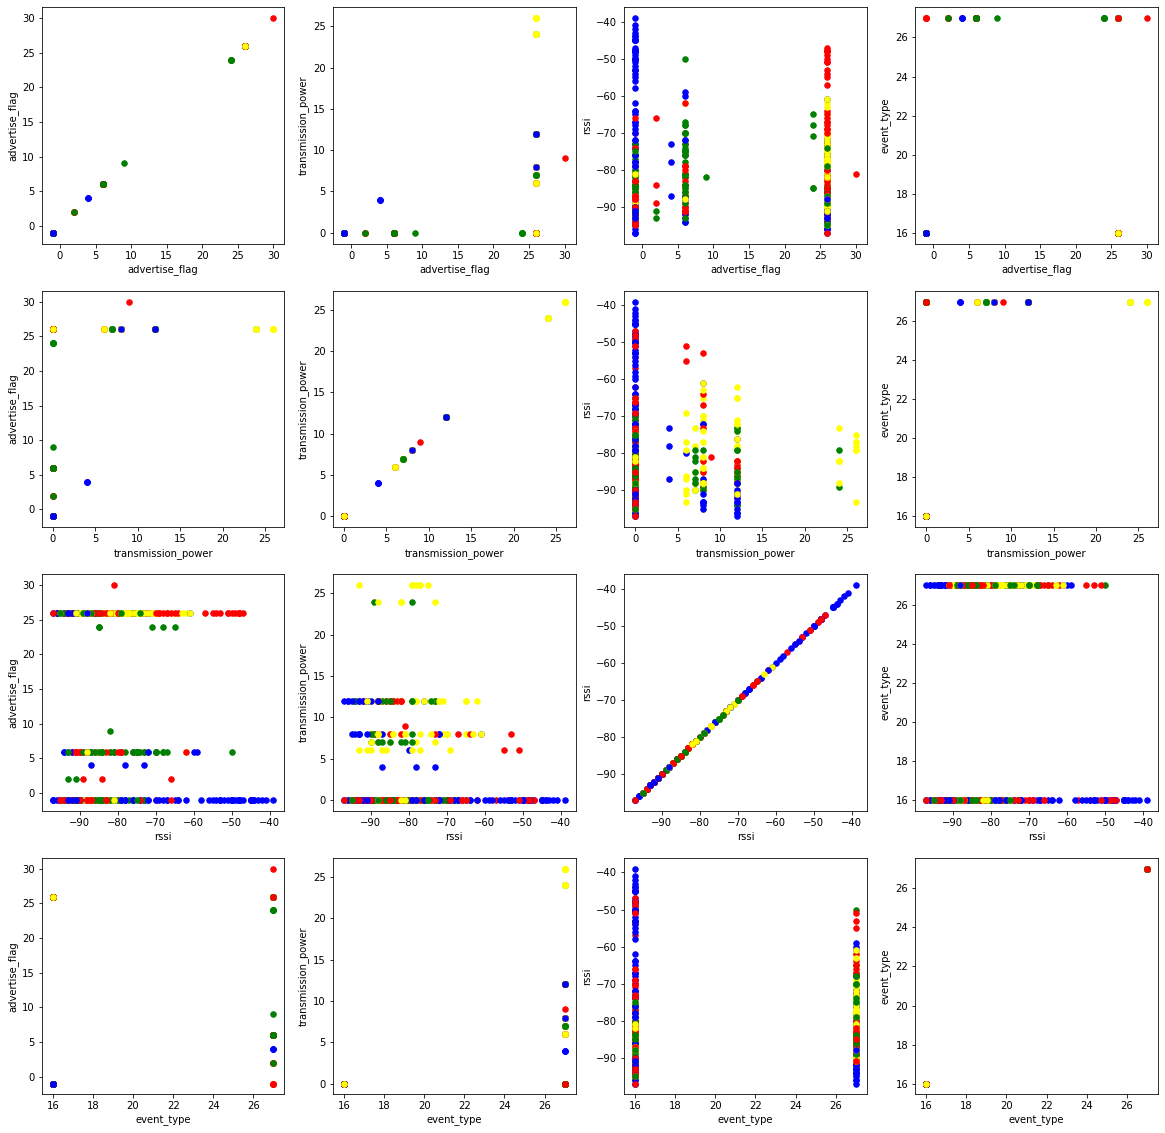

In [6]:
# assigning colors to each location
colors = {locations[0]:"red", locations[1]:"green", locations[2]:"blue", locations[3]:"yellow"}
print(colors)

# sampling 1% of random data to plot
fig, axs = plt.subplots(4, 4, figsize=(20,20))
shuffled_data = data4.sample(frac=0.01).reset_index(drop=True)

# plotting attribute_i vs attribute_j 
for i in range(4):
   for j in range(4):
       for location, x, y in shuffled_data[[columns2[0], columns2[i+3], columns2[j+3]]].values:
           axs[i,j].scatter(x, y, alpha=1, c=colors[location], s=30)
       axs[i,j].set_xlabel(columns2[i+3])
       axs[i,j].set_ylabel(columns2[j+3])
plt.show()

these featues doesn't provide a ton of discriminability. Let's test some classifiers anyway.

## Testing some classifiers

In [6]:
# shuffle the data and seperate it into training (70%) and testing data (30%)
shuffled_data = data4.sample(frac=1).reset_index(drop=True)
n = len(shuffled_data)

train_X = shuffled_data[columns2[3:]][:int(n*0.7)] # training attributes or training input
train_Y = shuffled_data['location'][:int(n*0.7)] # training labels or training output

test_X = shuffled_data[columns2[3:]][int(n*0.7):] # testing attributes or testing input
test_Y = shuffled_data['location'][int(n*0.7):] # testing labels or testing output

# create the classifiers
names = ["Nearest Neighbors", "Random Forest", "Decision Tree"]
classifiers = [
   KNeighborsClassifier(3),
   RandomForestClassifier(max_depth=5, n_estimators=30, max_features=4),
   DecisionTreeClassifier(max_depth=5)]

# iterate over classifiers and print scores
for name, clf in zip(names, classifiers):
   clf.fit(train_X, train_Y)
   score = clf.score(test_X, test_Y)
   print(name, ':', score)

Nearest Neighbors : 0.4987089634821099
Random Forest : 0.544325587114226
Decision Tree : 0.5309233984999385


## Feature Engineering

In [7]:
# names of new attributes
new_cols = ["n_beacons", "n_uniq_devices", "n_uniq_advflags",
           "avg_bcn_interval", "min_bcn_interval", "max_bcn_interval",
           "avg_txpwr", "min_txpwr", "max_txpwr", 
           "avg_rssi", "min_rssi", "max_rssi",
           "n_event16", "n_event27"]
columns3 = new_cols[:]

# function to get the interval of a beacons reappearnce
def get_bcn_intervals(instances, n):
   devices, intervals = np.unique(instances[:,1]), []
   for device in devices:
       device_filter = instances[:,1]==device
       timestamps = instances[:,0][device_filter]
       curr = timestamps[0]
       for timestamp in timestamps[1:]: intervals.append(round((timestamp-curr)/1000000000, 3))
   return intervals, len(intervals)

# function to create new features from the data
def get_features(instances, n):
   new_instance = [0 for _ in range(14)]
   # n_beacons
   new_instance[0] = n
   # n_uniq_devices
   try: new_instance[1] = len(np.unique(instances[:,1]))
   except: pass
   # n_uniq_advflags
   try: new_instance[2] = len(np.unique(instances[:,2]))
   except: pass
   # avg_bcn_interval
   try: 
       bcn_intervals, n_bcns = get_bcn_intervals(instances[:,0:2], n)
       if n_bcns!=0: new_instance[3] = round(np.sum(bcn_intervals)/n_bcns, 3)
       else: new_instance[3] = 0
   except: pass
   # min_bcn_interval
   try: new_instance[4] = round(np.min(bcn_intervals), 3)
   except: pass
   # max_bcn_interval
   try: new_instance[5] = round(np.max(bcn_intervals), 3)
   except: pass
   # avg_txpwr
   try: 
       txpwrs = instances[:,3]
       new_instance[6] = round(np.sum(txpwrs)/n,3)
   except: pass
   # min_txpwr
   try: new_instance[7] = np.min(txpwrs)
   except: pass
   # max_txpwr
   try: new_instance[8] = np.max(txpwrs)
   except: pass
   # avg_rssi
   try: 
       rssi = instances[:,4]
       new_instance[9] = round(sum(rssi)/n,3)
   except: pass
   # min_rssi
   try: new_instance[10] = np.min(rssi)
   except: pass
   # max_rssi
   try: new_instance[11] = np.max(rssi)
   except: pass
   # n_event16
   events, counts = np.unique(instances[:,5], return_counts=True)
   ct = dict()
   for e, c in zip(events, counts): ct[e] = c
   try: new_instance[12] = ct[16]
   except: pass
   # n_event27
   try: new_instance[13] = ct[27]
   except: pass
   return new_instance

# data5 is a dictionary containing new engineered data from each location
data5, interval = dict(), 5000000000
for location in locations:
   data3[location] = data3[location].sort_values(by=['timestamp'])
   data5[location], i, instances = list(), 0, data3[location].values
   n = len(instances)
   while i<n:
       start, end = i, i+1
       while end<n and (instances[end][0]-instances[start][0])<interval: end+=1
       data5[location].append(get_features(instances[start:end],end-start))
       i = end
data5 = {location: pd.DataFrame(data5[location], columns=new_cols) for location in locations}

# data6 gathers data from each location into a Dataframe by adding location as an attribute
data6 = pd.DataFrame(
   [ [location]+list(instance) 
    for location in locations 
    for instance in data5[location].values ], 
   columns=['location']+columns3
)
data6.head()

,location,n_beacons,n_uniq_devices,n_uniq_advflags,avg_bcn_interval,min_bcn_interval,max_bcn_interval,avg_txpwr,min_txpwr,max_txpwr,avg_rssi,min_rssi,max_rssi,n_event16,n_event27
0,public_transport,10.0,5.0,2.0,3.309,0.275,4.478,1.200,0.0,12.0,-81.200,-93.0,-69.0,8.0,2.0
1,public_transport,34.0,12.0,3.0,0.733,0.102,4.619,0.706,0.0,12.0,-89.765,-97.0,-79.0,19.0,15.0
2,public_transport,76.0,16.0,3.0,2.099,0.009,4.755,0.421,0.0,8.0,-86.513,-97.0,-44.0,40.0,36.0
3,public_transport,38.0,9.0,3.0,2.283,0.049,4.648,2.105,0.0,12.0,-87.368,-97.0,-42.0,8.0,30.0
4,public_transport,14.0,4.0,2.0,0.312,0.047,0.747,0.000,0.0,0.0,-86.643,-94.0,-44.0,1.0,13.0


## Plotting the new data

{'public_transport': 'red', 'outdoors': 'green', 'indoors': 'blue', 'super_market': 'yellow'}


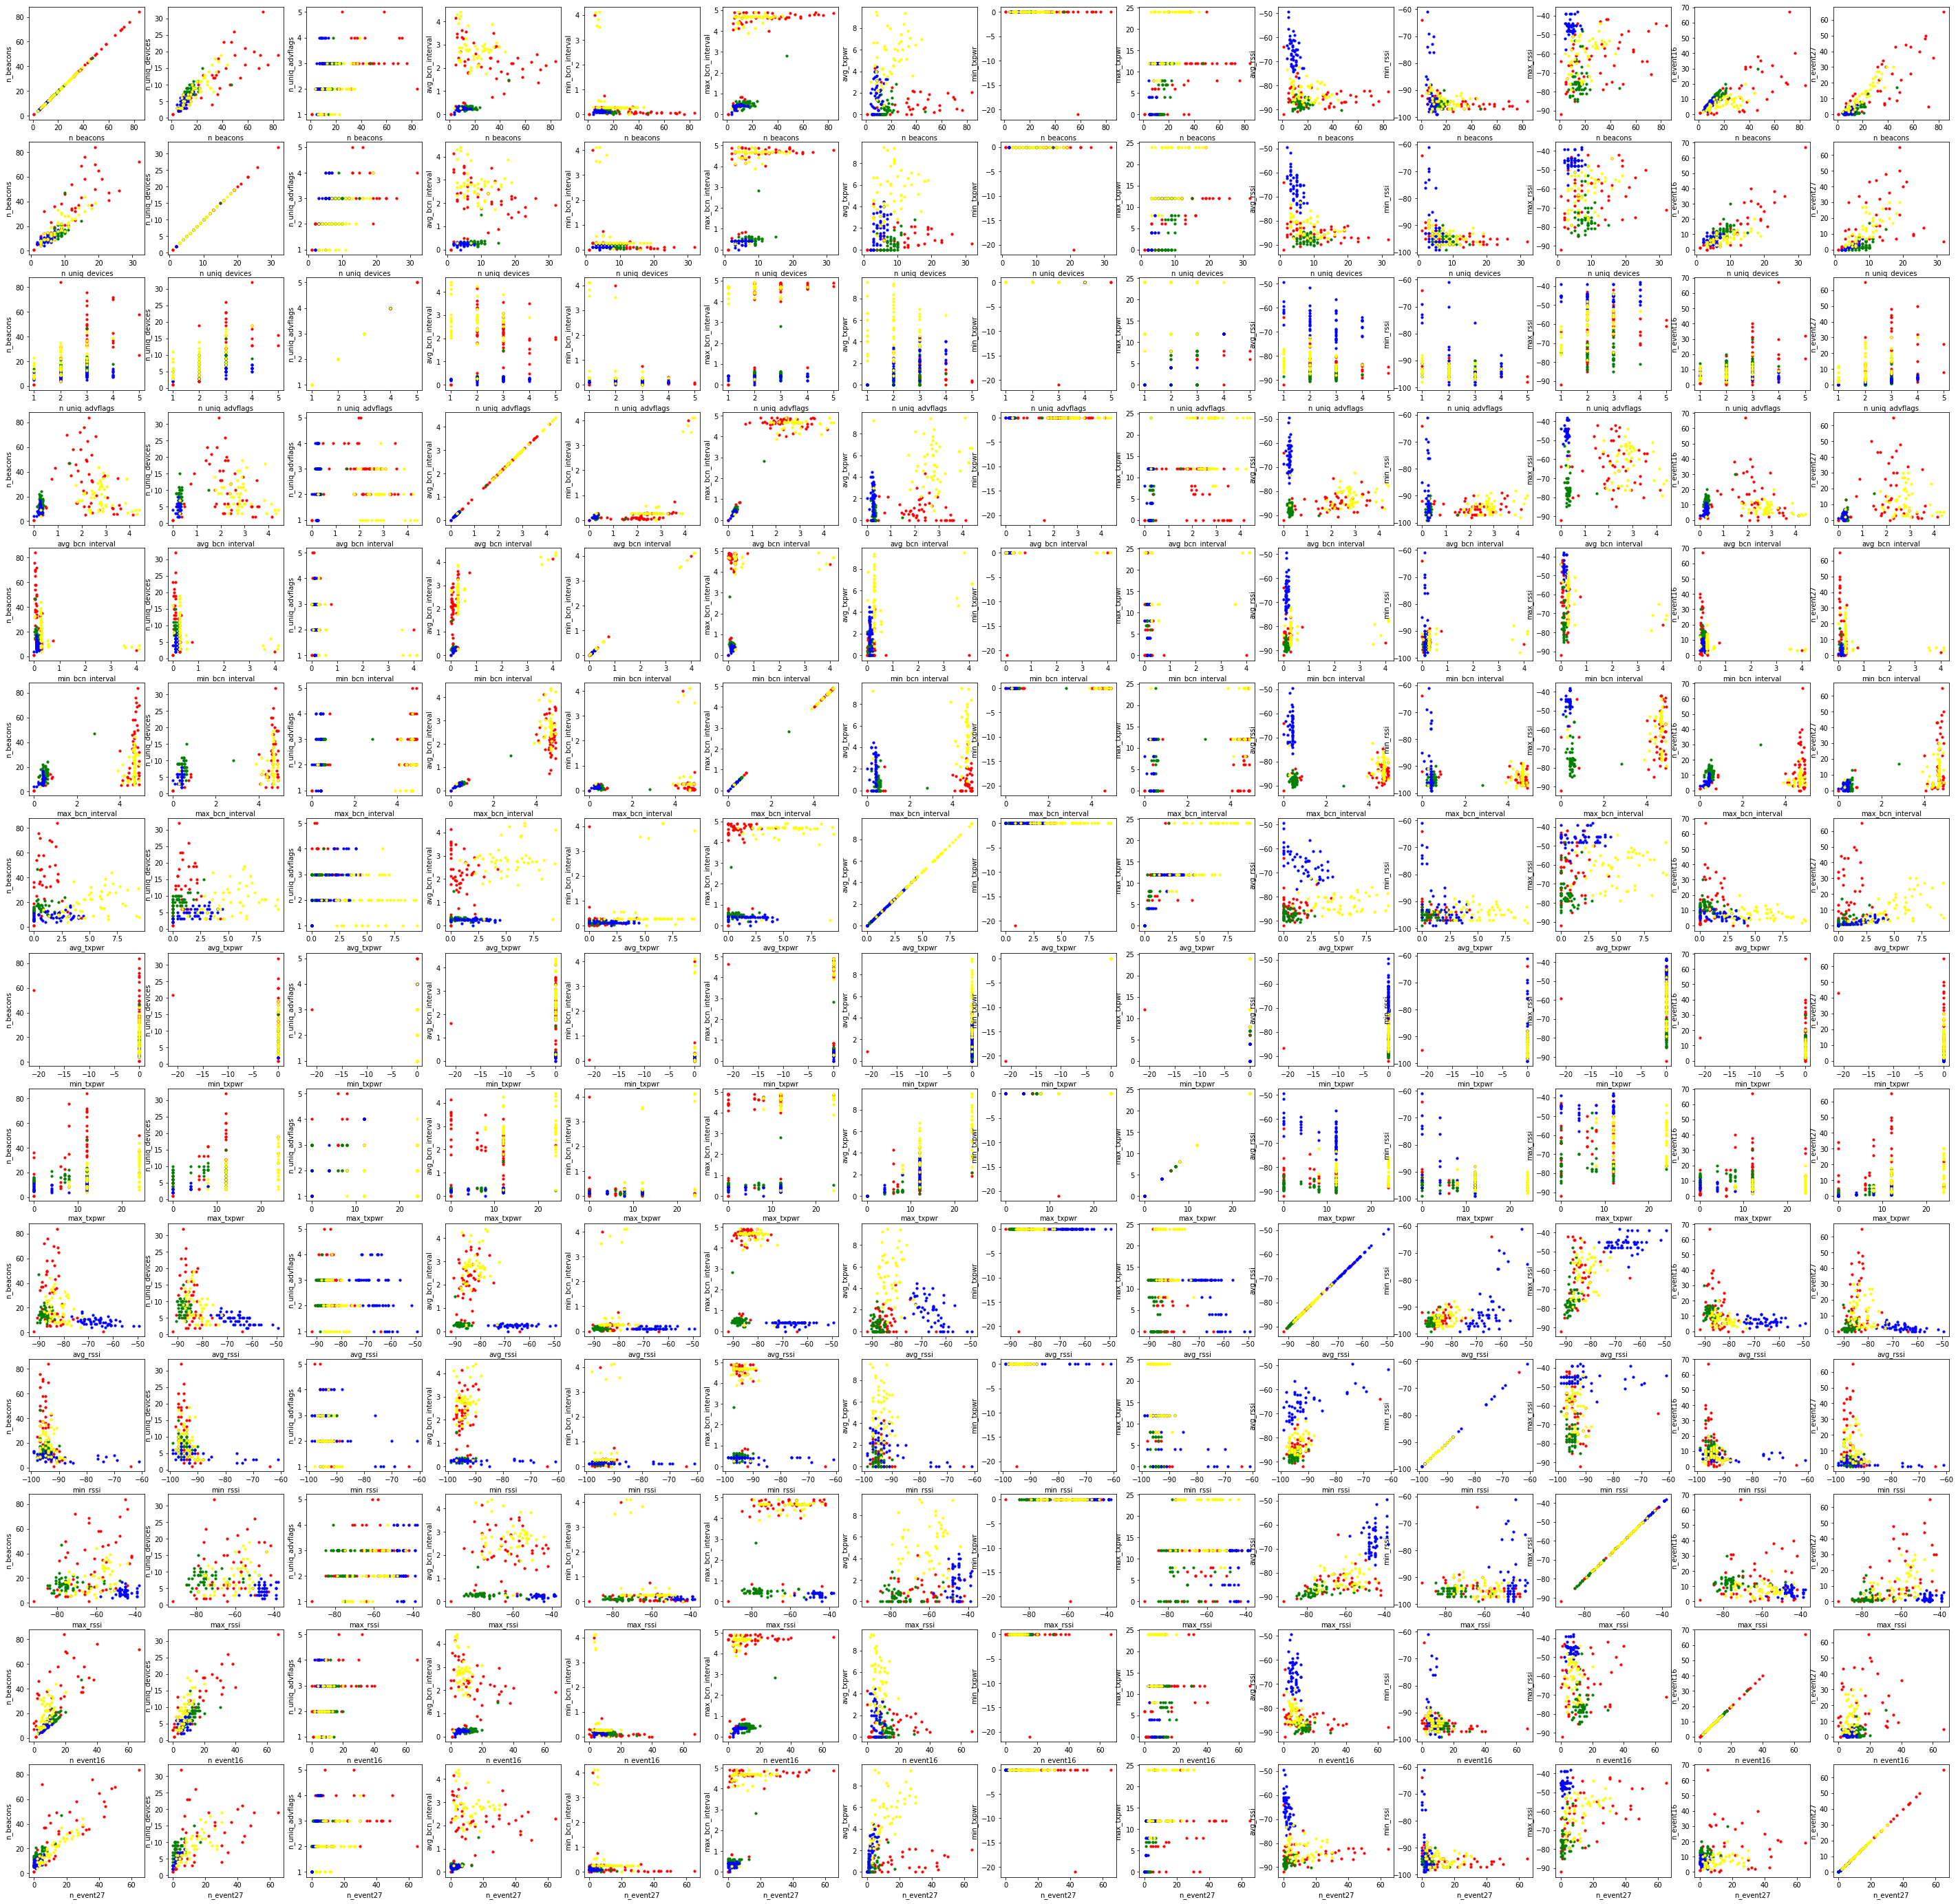

In [9]:
# assigning colors to each location
colors = {locations[0]:"red", locations[1]:"green", locations[2]:"blue", locations[3]:"yellow"}
print(colors)

# plotting attribute_i vs attribute_j 
fig, axs = plt.subplots(14, 14, figsize=(50,50))
for i in range(14):
   for j in range(14):
       for location in locations:
           for x, y in data5[location][[columns3[i], columns3[j]]].values[:50]:
               axs[i,j].scatter(x, y, alpha=1, c=colors[location], s=10)
       axs[i,j].set_xlabel(columns3[i])
       axs[i,j].set_ylabel(columns3[j])
plt.show()

## Testing classifiers with new data

In [69]:
# preparing data for classification
attributes = new_cols
shuffled_data = data6.sample(frac=1).reset_index(drop=True)
n_sample = len(shuffled_data)
train_X = shuffled_data[attributes][:int(n_sample*0.7)]
train_Y = shuffled_data['location'][:int(n_sample*0.7)]
test_X = shuffled_data[attributes][int(n_sample*0.7):]
test_Y = shuffled_data['location'][int(n_sample*0.7):]

# creating different classifiers
names = ["Nearest Neighbors", "Random Forest", "Decision Tree"]
classifiers = [
   KNeighborsClassifier(10),
   RandomForestClassifier(max_depth=10, n_estimators=20, max_features=10),
   DecisionTreeClassifier(max_depth=10)]

# iterate over classifiers and print their scores
for name, clf in zip(names, classifiers):
   clf.fit(train_X, train_Y)
   score = clf.score(test_X, test_Y)
   print(name, ':', score)

Nearest Neighbors : 0.851138353765324
Random Forest : 0.9089316987740805
Decision Tree : 0.8633975481611208


In [70]:
for location in locations:
    count = dict()
    test_X, test_Y = data5[location], [location]*len(data5[location])
    score = clf.score(test_X, test_Y)
    pred_Y = clf.predict(test_X)
    total = len(pred_Y)
    for y in pred_Y:
        try: count[y] += 1
        except: count[y] = 1
    for k in count.keys(): count[k] = round(count[k]/total,3)
    print(location,':',round(score,3))
    print(count)

public_transport : 0.891
{'public_transport': 0.891, 'outdoors': 0.057, 'indoors': 0.026, 'super_market': 0.026}
outdoors : 0.879
{'outdoors': 0.879, 'indoors': 0.021, 'public_transport': 0.07, 'super_market': 0.03}
indoors : 0.995
{'indoors': 0.995, 'public_transport': 0.004, 'outdoors': 0.001}
super_market : 0.972
{'indoors': 0.01, 'super_market': 0.972, 'public_transport': 0.015, 'outdoors': 0.003}


## showing the decision tree

In [76]:
tree_rules = tree.export_text(clf)
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (32,18), dpi=300)
#tree.plot_tree(clf,
#               feature_names = new_cols, 
#               class_names=locations,
#               filled = True);

## converting decision tree to java code

In [73]:
tree_rules.split('\n')

['|--- feature_11 <= -52.50',
 '|   |--- feature_6 <= 4.14',
 '|   |   |--- feature_5 <= 4.26',
 '|   |   |   |--- feature_11 <= -55.50',
 '|   |   |   |   |--- feature_0 <= 11.50',
 '|   |   |   |   |   |--- feature_9 <= -81.17',
 '|   |   |   |   |   |   |--- feature_5 <= 4.03',
 '|   |   |   |   |   |   |   |--- feature_11 <= -88.50',
 '|   |   |   |   |   |   |   |   |--- feature_10 <= -93.00',
 '|   |   |   |   |   |   |   |   |   |--- class: super_market',
 '|   |   |   |   |   |   |   |   |--- feature_10 >  -93.00',
 '|   |   |   |   |   |   |   |   |   |--- feature_5 <= 1.76',
 '|   |   |   |   |   |   |   |   |   |   |--- class: public_transport',
 '|   |   |   |   |   |   |   |   |   |--- feature_5 >  1.76',
 '|   |   |   |   |   |   |   |   |   |   |--- class: outdoors',
 '|   |   |   |   |   |   |   |--- feature_11 >  -88.50',
 '|   |   |   |   |   |   |   |   |--- feature_13 <= 4.00',
 '|   |   |   |   |   |   |   |   |   |--- feature_9 <= -82.44',
 '|   |   |   |   |   | 

In [115]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def pos_pos(arr):
        for i in range(4):
            if arr[i]>0: return '\"'+["indoors", "outdoors", "public_transport", "super_market"][i]+'\";'

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if({} <= {})\n".format(indent, name, threshold)+indent+'{')
            recurse(tree_.children_left[node], depth + 1)
            print(indent+'}')
            print("{}else\n".format(indent, name, threshold)+indent+'{')
            recurse(tree_.children_right[node], depth + 1)
            print(indent+'}')
        else:
            print("{}return {}".format(indent, pos_pos(tree_.value[node][0])))

    recurse(0, 1)
    
tree_to_code(clf, ['features['+str(i)+']' for i in range(14)])

  if(features[11] <= -52.5)
  {
    if(features[6] <= 4.13949990272522)
    {
      if(features[5] <= 4.260999917984009)
      {
        if(features[11] <= -55.5)
        {
          if(features[0] <= 11.5)
          {
            if(features[9] <= -81.17499923706055)
            {
              if(features[5] <= 4.033500075340271)
              {
                if(features[11] <= -88.5)
                {
                  if(features[10] <= -93.0)
                  {
                    return "super_market";
                  }
                  else
                  {
                    if(features[5] <= 1.7649999856948853)
                    {
                      return "public_transport";
                    }
                    else
                    {
                      return "outdoors";
                    }
                  }
                }
                else
                {
                  if(features[13] <= 4.0)
                  {
                    

## Testing data from USA - Indoors

In [14]:
# load usa_data from json file to usa_data1 of type dictionary
usa_data2 = {'indoors':json.load(open('data_usa.json'))}
locations = list(usa_data2.keys())
print('usa_data collected in location types:\n',locations)

# function to convert usa_data from string to a list of attribute values
def parse(x): 
 start = x.find('device=')+7; end = start+x[start:].find(",")
 device = x[start:end]; x=x[end:]
 start = x.find('mAdvertiseFlags=')+16; end = start+x[start:].find(",")
 mAdvertiseFlags = int(x[start:end]); x=x[end:]
 start = x.find('mTxPowerLevel=')+14; end = start+x[start:].find(",")
 mTxPowerLevel = int(x[start:end]); x=x[end:]
 start = x.find('rssi=')+5; end = start+x[start:].find(",")
 rssi = int(x[start:end]); x=x[end:]
 start = x.find('timestampNanos=')+15; end = start+x[start:].find(",")
 timestampNanos = int(x[start:end]);x=x[end:]
 start = x.find('eventType=')+10; end = start+x[start:].find(",")
 eventType = int(x[start:end]); x=x[end:]
 start = x.find('primaryPhy=')+11; end = start+x[start:].find(",")
 primaryPhy = int(x[start:end]); x=x[end:]
 start = x.find('secondaryPhy=')+13; end = start+x[start:].find(",")
 secondaryPhy = int(x[start:end]); x=x[end:]
 start = x.find('advertisingSid=')+15; end = start+x[start:].find(",")
 advertisingSid = int(x[start:end]); x=x[end:]
 start = x.find('txPower=')+8; end = start+x[start:].find(",")
 txPower = int(x[start:end]); x=x[end:]
 start = x.find('periodicAdvertisingInterval=')+28; end = start+x[start:].find("}")
 periodicAdvertisingInterval = x[start:end]; x=x[end:]
 if mTxPowerLevel<-999: mTxPowerLevel = 0
 return [ timestampNanos, device, mAdvertiseFlags, mTxPowerLevel, rssi, eventType, primaryPhy, secondaryPhy, advertisingSid, txPower, periodicAdvertisingInterval ]

# these are the attributes collected from the ble beacons
columns1 = ["timestamp", "device_id", "advertise_flag", "transmission_power", "rssi", "event_type", "primary_phy", "secondary_phy", "advertising_sid", "tx_power", "advertising_interval"]

# usa_data3 is a dictionary with location names a keys and the usa_data collected in each location as values as a Pandas usa_dataframe type.
usa_data3 = { location: pd.DataFrame([parse(instance) for instance in usa_data2[location].values()], columns=columns1) for location in locations}

# the new attributes after dropping some columns and adding location as a column
columns2 = ["location", "timestamp", "device_id", "advertise_flag", "transmission_power", "rssi", "event_type"]

# usa_data4 is a usa_dataframe containing values of attributes from columns2 in all locations
usa_data4 = pd.DataFrame(
   [[location]+list(instance) 
    for location in locations 
    for instance in usa_data3[location][columns2[1:]].values], 
   columns=columns2
)

# names of new attributes
new_cols = ["n_beacons", "n_uniq_devices", "n_uniq_advflags",
           "avg_bcn_interval", "min_bcn_interval", "max_bcn_interval",
           "avg_txpwr", "min_txpwr", "max_txpwr", 
           "avg_rssi", "min_rssi", "max_rssi",
           "n_event16", "n_event27"]
columns3 = new_cols[:]

# function to get the interval of a beacons reappearnce
def get_bcn_intervals(instances, n):
   devices, intervals = np.unique(instances[:,1]), []
   for device in devices:
       device_filter = instances[:,1]==device
       timestamps = instances[:,0][device_filter]
       curr = timestamps[0]
       for timestamp in timestamps[1:]: intervals.append(round((timestamp-curr)/1000000000, 3))
   return intervals, len(intervals)

# function to create new features from the usa_data
def get_features(instances, n):
   new_instance = [0 for _ in range(14)]
   # n_beacons
   new_instance[0] = n
   # n_uniq_devices
   try: new_instance[1] = len(np.unique(instances[:,1]))
   except: pass
   # n_uniq_advflags
   try: new_instance[2] = len(np.unique(instances[:,2]))
   except: pass
   # avg_bcn_interval
   try: 
       bcn_intervals, n_bcns = get_bcn_intervals(instances[:,0:2], n)
       if n_bcns!=0: new_instance[3] = round(np.sum(bcn_intervals)/n_bcns, 3)
       else: new_instance[3] = 0
   except: pass
   # min_bcn_interval
   try: new_instance[4] = round(np.min(bcn_intervals), 3)
   except: pass
   # max_bcn_interval
   try: new_instance[5] = round(np.max(bcn_intervals), 3)
   except: pass
   # avg_txpwr
   try: 
       txpwrs = instances[:,3]
       new_instance[6] = round(np.sum(txpwrs)/n,3)
   except: pass
   # min_txpwr
   try: new_instance[7] = np.min(txpwrs)
   except: pass
   # max_txpwr
   try: new_instance[8] = np.max(txpwrs)
   except: pass
   # avg_rssi
   try: 
       rssi = instances[:,4]
       new_instance[9] = round(sum(rssi)/n,3)
   except: pass
   # min_rssi
   try: new_instance[10] = np.min(rssi)
   except: pass
   # max_rssi
   try: new_instance[11] = np.max(rssi)
   except: pass
   # n_event16
   events, counts = np.unique(instances[:,5], return_counts=True)
   ct = dict()
   for e, c in zip(events, counts): ct[e] = c
   try: new_instance[12] = ct[16]
   except: pass
   # n_event27
   try: new_instance[13] = ct[27]
   except: pass
   return new_instance

# usa_data5 is a dictionary containing new engineered usa_data from each location
usa_data5, interval = dict(), 5000000000
for location in locations:
   usa_data3[location] = usa_data3[location].sort_values(by=['timestamp'])
   usa_data5[location], i, instances = list(), 0, usa_data3[location].values
   n = len(instances)
   while i<n:
       start, end = i, i+1
       while end<n and (instances[end][0]-instances[start][0])<interval: end+=1
       usa_data5[location].append(get_features(instances[start:end],end-start))
       i = end
usa_data5 = {location: pd.DataFrame(usa_data5[location], columns=new_cols) for location in locations}

# usa_data6 gathers usa_data from each location into a usa_dataframe by adding location as an attribute
usa_data6 = pd.DataFrame(
   [ [location]+list(instance) 
    for location in locations 
    for instance in usa_data5[location].values ], 
   columns=['location']+columns3
)

# preparing data for classification
attributes = new_cols
shuffled_data = usa_data6.sample(frac=1).reset_index(drop=True)
test_X = shuffled_data[attributes]
test_Y = shuffled_data['location']

for location in locations:
    count = dict()
    test_X, test_Y = data5[location], [location]*len(data5[location])
    score = clf.score(test_X, test_Y)
    pred_Y = clf.predict(test_X)
    total = len(pred_Y)
    for y in pred_Y:
        try: count[y] += 1
        except: count[y] = 1
    for k in count.keys(): count[k] = round(count[k]/total,3)
    print(location,':',round(score,3))
    print(count)

usa_data collected in location types:
 ['indoors']
indoors : 0.998
{'indoors': 0.998, 'outdoors': 0.002}


In [17]:
# load india_data from json file to india_data1 of type dictionary
india_data2 = {'outdoors':json.load(open('data_india.json'))}
locations = list(india_data2.keys())
print('india_data collected in location types:\n',locations)

# function to convert india_data from string to a list of attribute values
def parse(x): 
 start = x.find('device=')+7; end = start+x[start:].find(",")
 device = x[start:end]; x=x[end:]
 start = x.find('mAdvertiseFlags=')+16; end = start+x[start:].find(",")
 mAdvertiseFlags = int(x[start:end]); x=x[end:]
 start = x.find('mTxPowerLevel=')+14; end = start+x[start:].find(",")
 mTxPowerLevel = int(x[start:end]); x=x[end:]
 start = x.find('mRssi=')+6; end = start+x[start:].find(",")
 rssi = int(x[start:end]); x=x[end:]
 start = x.find('mTimestampNanos=')+16; end = start+x[start:].find("}")
 timestampNanos = int(x[start:end]);x=x[end:]
 return [ timestampNanos, device, mAdvertiseFlags, mTxPowerLevel, rssi, 0]

# these are the attributes collected from the ble beacons
columns1 = ["timestamp", "device_id", "advertise_flag", "transmission_power", "rssi", "event_type"]

# india_data3 is a dictionary with location names a keys and the india_data collected in each location as values as a Pandas india_dataframe type.
india_data3 = { location: pd.DataFrame([parse(instance) for instance in india_data2[location].values()], columns=columns1) for location in locations}

# the new attributes after dropping some columns and adding location as a column
columns2 = ["location", "timestamp", "device_id", "advertise_flag", "transmission_power", "rssi", "event_type"]

# india_data4 is a india_dataframe containing values of attributes from columns2 in all locations
india_data4 = pd.DataFrame(
   [[location]+list(instance) 
    for location in locations 
    for instance in india_data3[location][columns2[1:]].values], 
   columns=columns2
)

# names of new attributes
new_cols = ["n_beacons", "n_uniq_devices", "n_uniq_advflags",
           "avg_bcn_interval", "min_bcn_interval", "max_bcn_interval",
           "avg_txpwr", "min_txpwr", "max_txpwr", 
           "avg_rssi", "min_rssi", "max_rssi",
           "n_event16", "n_event27"]
columns3 = new_cols[:]

# function to get the interval of a beacons reappearnce
def get_bcn_intervals(instances, n):
   devices, intervals = np.unique(instances[:,1]), []
   for device in devices:
       device_filter = instances[:,1]==device
       timestamps = instances[:,0][device_filter]
       curr = timestamps[0]
       for timestamp in timestamps[1:]: intervals.append(round((timestamp-curr)/1000000000, 3))
   return intervals, len(intervals)

# function to create new features from the india_data
def get_features(instances, n):
   new_instance = [0 for _ in range(14)]
   # n_beacons
   new_instance[0] = n
   # n_uniq_devices
   try: new_instance[1] = len(np.unique(instances[:,1]))
   except: pass
   # n_uniq_advflags
   try: new_instance[2] = len(np.unique(instances[:,2]))
   except: pass
   # avg_bcn_interval
   try: 
       bcn_intervals, n_bcns = get_bcn_intervals(instances[:,0:2], n)
       if n_bcns!=0: new_instance[3] = round(np.sum(bcn_intervals)/n_bcns, 3)
       else: new_instance[3] = 0
   except: pass
   # min_bcn_interval
   try: new_instance[4] = round(np.min(bcn_intervals), 3)
   except: pass
   # max_bcn_interval
   try: new_instance[5] = round(np.max(bcn_intervals), 3)
   except: pass
   # avg_txpwr
   try: 
       txpwrs = instances[:,3]
       new_instance[6] = round(np.sum(txpwrs)/n,3)
   except: pass
   # min_txpwr
   try: new_instance[7] = np.min(txpwrs)
   except: pass
   # max_txpwr
   try: new_instance[8] = np.max(txpwrs)
   except: pass
   # avg_rssi
   try: 
       rssi = instances[:,4]
       new_instance[9] = round(sum(rssi)/n,3)
   except: pass
   # min_rssi
   try: new_instance[10] = np.min(rssi)
   except: pass
   # max_rssi
   try: new_instance[11] = np.max(rssi)
   except: pass
   # n_event16
   events, counts = np.unique(instances[:,5], return_counts=True)
   ct = dict()
   for e, c in zip(events, counts): ct[e] = c
   try: new_instance[12] = ct[16]
   except: pass
   # n_event27
   try: new_instance[13] = ct[27]
   except: pass
   return new_instance

# india_data5 is a dictionary containing new engineered india_data from each location
india_data5, interval = dict(), 5000000000
for location in locations:
   india_data3[location] = india_data3[location].sort_values(by=['timestamp'])
   india_data5[location], i, instances = list(), 0, india_data3[location].values
   n = len(instances)
   while i<n:
       start, end = i, i+1
       while end<n and (instances[end][0]-instances[start][0])<interval: end+=1
       india_data5[location].append(get_features(instances[start:end],end-start))
       i = end
india_data5 = {location: pd.DataFrame(india_data5[location], columns=new_cols) for location in locations}

# india_data6 gathers india_data from each location into a india_dataframe by adding location as an attribute
india_data6 = pd.DataFrame(
   [ [location]+list(instance) 
    for location in locations 
    for instance in india_data5[location].values ], 
   columns=['location']+columns3
)

# preparing data for classification
attributes = new_cols
shuffled_data = india_data6.sample(frac=1).reset_index(drop=True)
test_X = shuffled_data[attributes]
test_Y = shuffled_data['location']

for location in locations:
    count = dict()
    test_X, test_Y = data5[location], [location]*len(data5[location])
    score = clf.score(test_X, test_Y)
    pred_Y = clf.predict(test_X)
    total = len(pred_Y)
    for y in pred_Y:
        try: count[y] += 1
        except: count[y] = 1
    for k in count.keys(): count[k] = round(count[k]/total,3)
    print(location,':',round(score,3))
    print(count)

india_data collected in location types:
 ['outdoors']
outdoors : 0.944
{'outdoors': 0.944, 'public_transport': 0.028, 'indoors': 0.009, 'super_market': 0.019}


In [16]:
np.unique(clf.predict([[0 for _ in range(14)] for _ in range(1000)]), return_counts=True)

(array(['public_transport'], dtype=object), array([100], dtype=int64))